In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_15 import VitalSignsDataset,vital_pre_train
from model.lstm.autoencoder_v3_lstm import *
from model.lstm.autoencoder_v3_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-03 15:43:06.749745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=16, shuffle=False, collate_fn=vital_pre_train)


labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [2]:
from torch.utils.data import DataLoader, TensorDataset

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
dataset_train = VitalSignsDataset(vital_signs_train)

labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=vital_pre_train )
small_data_iter = iter(train_loader) 
inputs, lengths,idx,cat  = next(small_data_iter)   

original_indices = torch.arange(len(inputs))
small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/resampled_15"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
# stage1_dir = os.path.join(base_dir, "stage1")
stage1_dir = os.path.join(base_dir, "stage1_debug")
model1, hist_ae = train_vae(model, small_train_loader, device, optimizer=optimizer_ae, start=0,epochs=400, save_dir=stage1_dir, patience=50,kl_warmup_epochs=200)

[VAE Pretrain] Epoch 50/400 Avg ELBO: -157.8225 (Recon: -157.9341, KLw: 0.1117)
[Epoch 100] KL weight: 0.0005, KL: 0.2543
[VAE Pretrain] Epoch 100/400 Avg ELBO: -237.7054 (Recon: -237.9598, KLw: 0.2543)
[VAE Pretrain] Epoch 150/400 Avg ELBO: -257.0666 (Recon: -257.4521, KLw: 0.3856)
[Epoch 200] KL weight: 0.0010, KL: 0.5146
[VAE Pretrain] Epoch 200/400 Avg ELBO: -260.8385 (Recon: -261.3531, KLw: 0.5146)
[VAE Pretrain] Epoch 250/400 Avg ELBO: -263.2497 (Recon: -263.7651, KLw: 0.5154)
[Epoch 300] KL weight: 0.0010, KL: 0.5133
[VAE Pretrain] Epoch 300/400 Avg ELBO: -274.2044 (Recon: -274.7177, KLw: 0.5133)
[VAE Pretrain] Epoch 350/400 Avg ELBO: -273.9148 (Recon: -274.4257, KLw: 0.5108)
[Epoch 400] KL weight: 0.0010, KL: 0.5084
[VAE Pretrain] Epoch 400/400 Avg ELBO: -270.5415 (Recon: -271.0499, KLw: 0.5084)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage1/best_ae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

In [ ]:
initialize_som_from_data(model, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [5]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=100,save_dir=stage2_dir,patience=50)

[SOM] Phase 1 Epoch 10/100 Avg Loss: 0.0693
[SOM] Phase 1 Epoch 20/100 Avg Loss: 0.0682
[SOM] Phase 1 Epoch 30/100 Avg Loss: 0.0675
[SOM] Phase 2 Epoch 40/100 Avg Loss: 0.0677
[SOM] Phase 2 Epoch 50/100 Avg Loss: 0.0672
[SOM] Phase 2 Epoch 60/100 Avg Loss: 0.0673
[SOM] Phase 3 Epoch 70/100 Avg Loss: 0.0640
[SOM] Phase 3 Epoch 80/100 Avg Loss: 0.0634
[SOM] Phase 3 Epoch 90/100 Avg Loss: 0.0638


In [4]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/best_som.pth'
model2 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

<All keys matched successfully>

In [8]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model2,train_loader, val_loader, train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 3126284
[Joint] Calculating  patient_start_offset_global (once before training)...


[Joint]  patient_start_offset_global calculated. Shape: torch.Size([2150])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


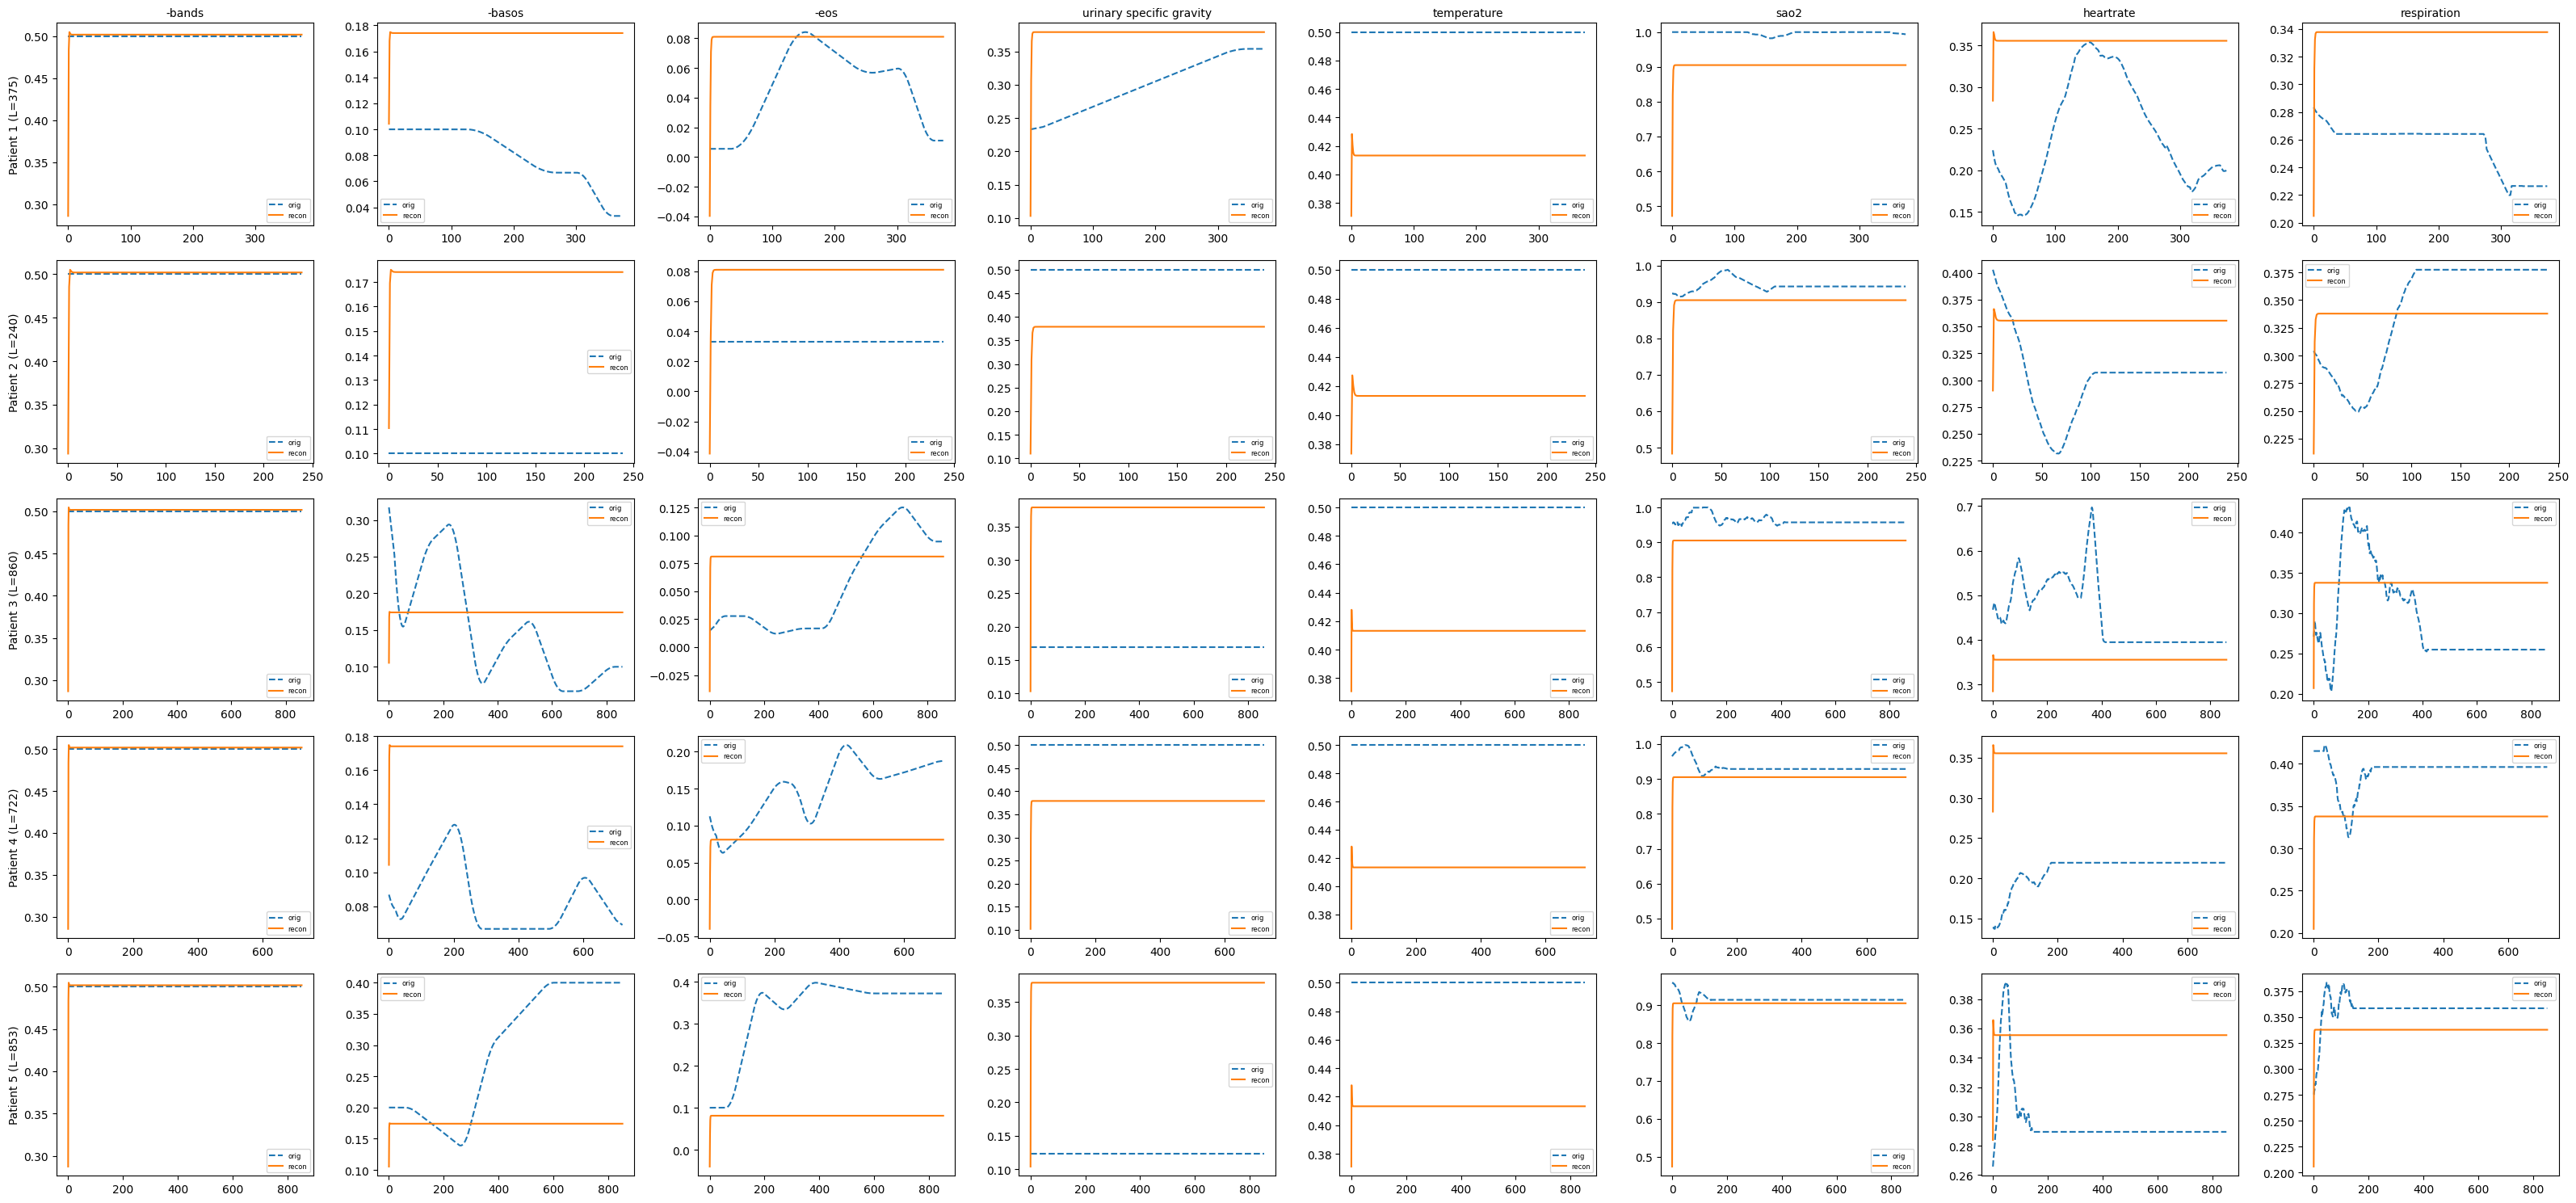

In [5]:
## 32
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]
selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model1, small_train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 9111 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0224
  Std (overall): 2.5068
  Per-dim mean:
tensor([-1.5043e+00,  3.2089e+00,  2.0015e+00, -2.1471e+00, -3.3374e+00,
         2.2322e+00, -2.1980e+00,  2.4309e+00, -6.0842e-01,  2.3908e+00,
        -1.8768e+00,  2.4418e+00, -9.6317e-01, -3.0329e+00, -3.3096e+00,
        -2.9541e+00, -2.9243e+00,  3.8870e+00, -3.4681e+00,  2.9780e+00,
         1.9026e+00,  2.6131e+00, -3.2221e+00,  3.2658e+00, -3.0483e+00,
        -2.9696e+00, -2.5069e+00,  1.6551e+00, -1.8079e+00, -2.0511e+00,
         1.8828e+00, -3.4960e+00, -2.0156e+00, -1.8067e+00, -2.6362e+00,
        -2.3326e+00,  2.8982e+00,  2.3936e+00, -2.6774e+00, -2.6245e+00,
        -3.5610e+00, -1.1870e-01, -2.2796e+00,  2.9427e+00,  2.9310e+00,
        -3.7105e+00,  3.3539e+00, -2.3269e+00, -3.1675e+00,  2.3014e+00,
         2.4674e+00, -1.3247e+00, -2.0935e+00,  1.7739e+00, -2.1269e+00,
        -2.1467e+00, -5.8245e-01,  2.63

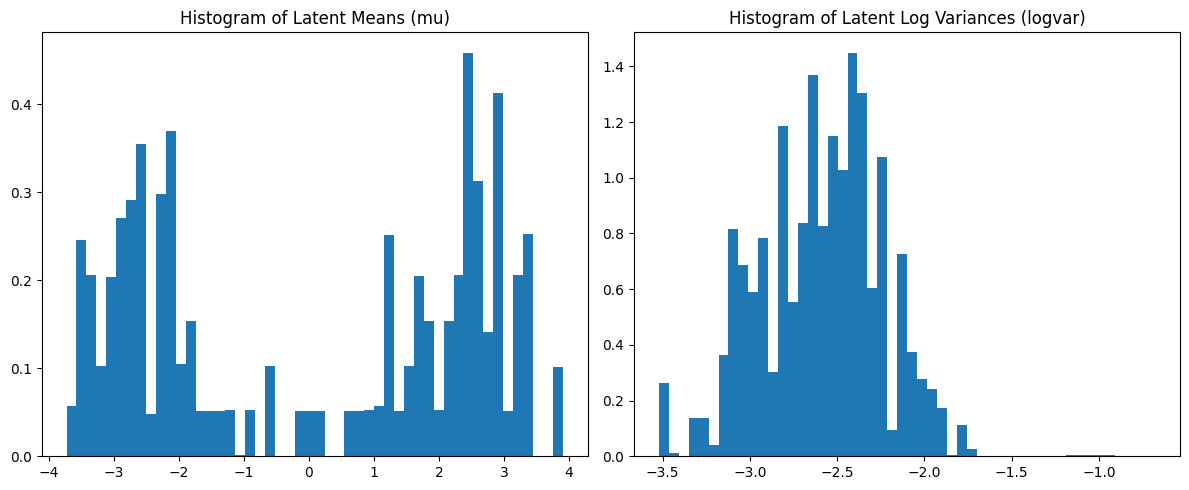

In [6]:
analyze_latent_stats(model1, small_train_loader, device, num_batches_to_analyze=20)

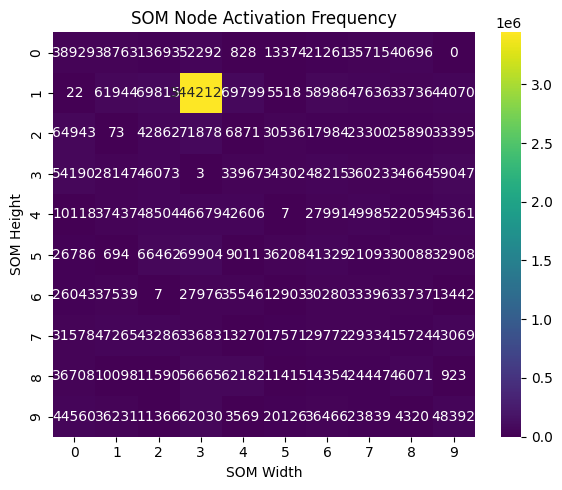

In [11]:
activation_map = compute_som_activation_heatmap(model3, train_loader, device)
plot_som_activation_heatmap(activation_map)

In [12]:
stage4_dir = os.path.join(base_dir, "stage4")

model4, hist_ae_ver2 = train_vae(model3, train_loader, device, optimizer=optimizer_ae, start=0,epochs=100, save_dir=stage4_dir, patience=50,kl_warmup_epochs=60)

[Epoch 9] KL weight: 0.0001, KL: 0.0425
[Epoch 19] KL weight: 0.0002, KL: 0.0898
[Epoch 29] KL weight: 0.0002, KL: 0.1371
[Epoch 39] KL weight: 0.0003, KL: 0.1843
[Epoch 49] KL weight: 0.0004, KL: 0.2316
[VAE Pretrain] Epoch 50/100 Avg ELBO: -363.3498 (Recon: -363.5813, KLw: 0.2316)
[Epoch 59] KL weight: 0.0005, KL: 0.2788
[Epoch 69] KL weight: 0.0006, KL: 0.3261
[Epoch 79] KL weight: 0.0007, KL: 0.3734
[Epoch 89] KL weight: 0.0007, KL: 0.4206
[Epoch 99] KL weight: 0.0008, KL: 0.4677
[VAE Pretrain] Epoch 100/100 Avg ELBO: -362.7376 (Recon: -363.2053, KLw: 0.4677)


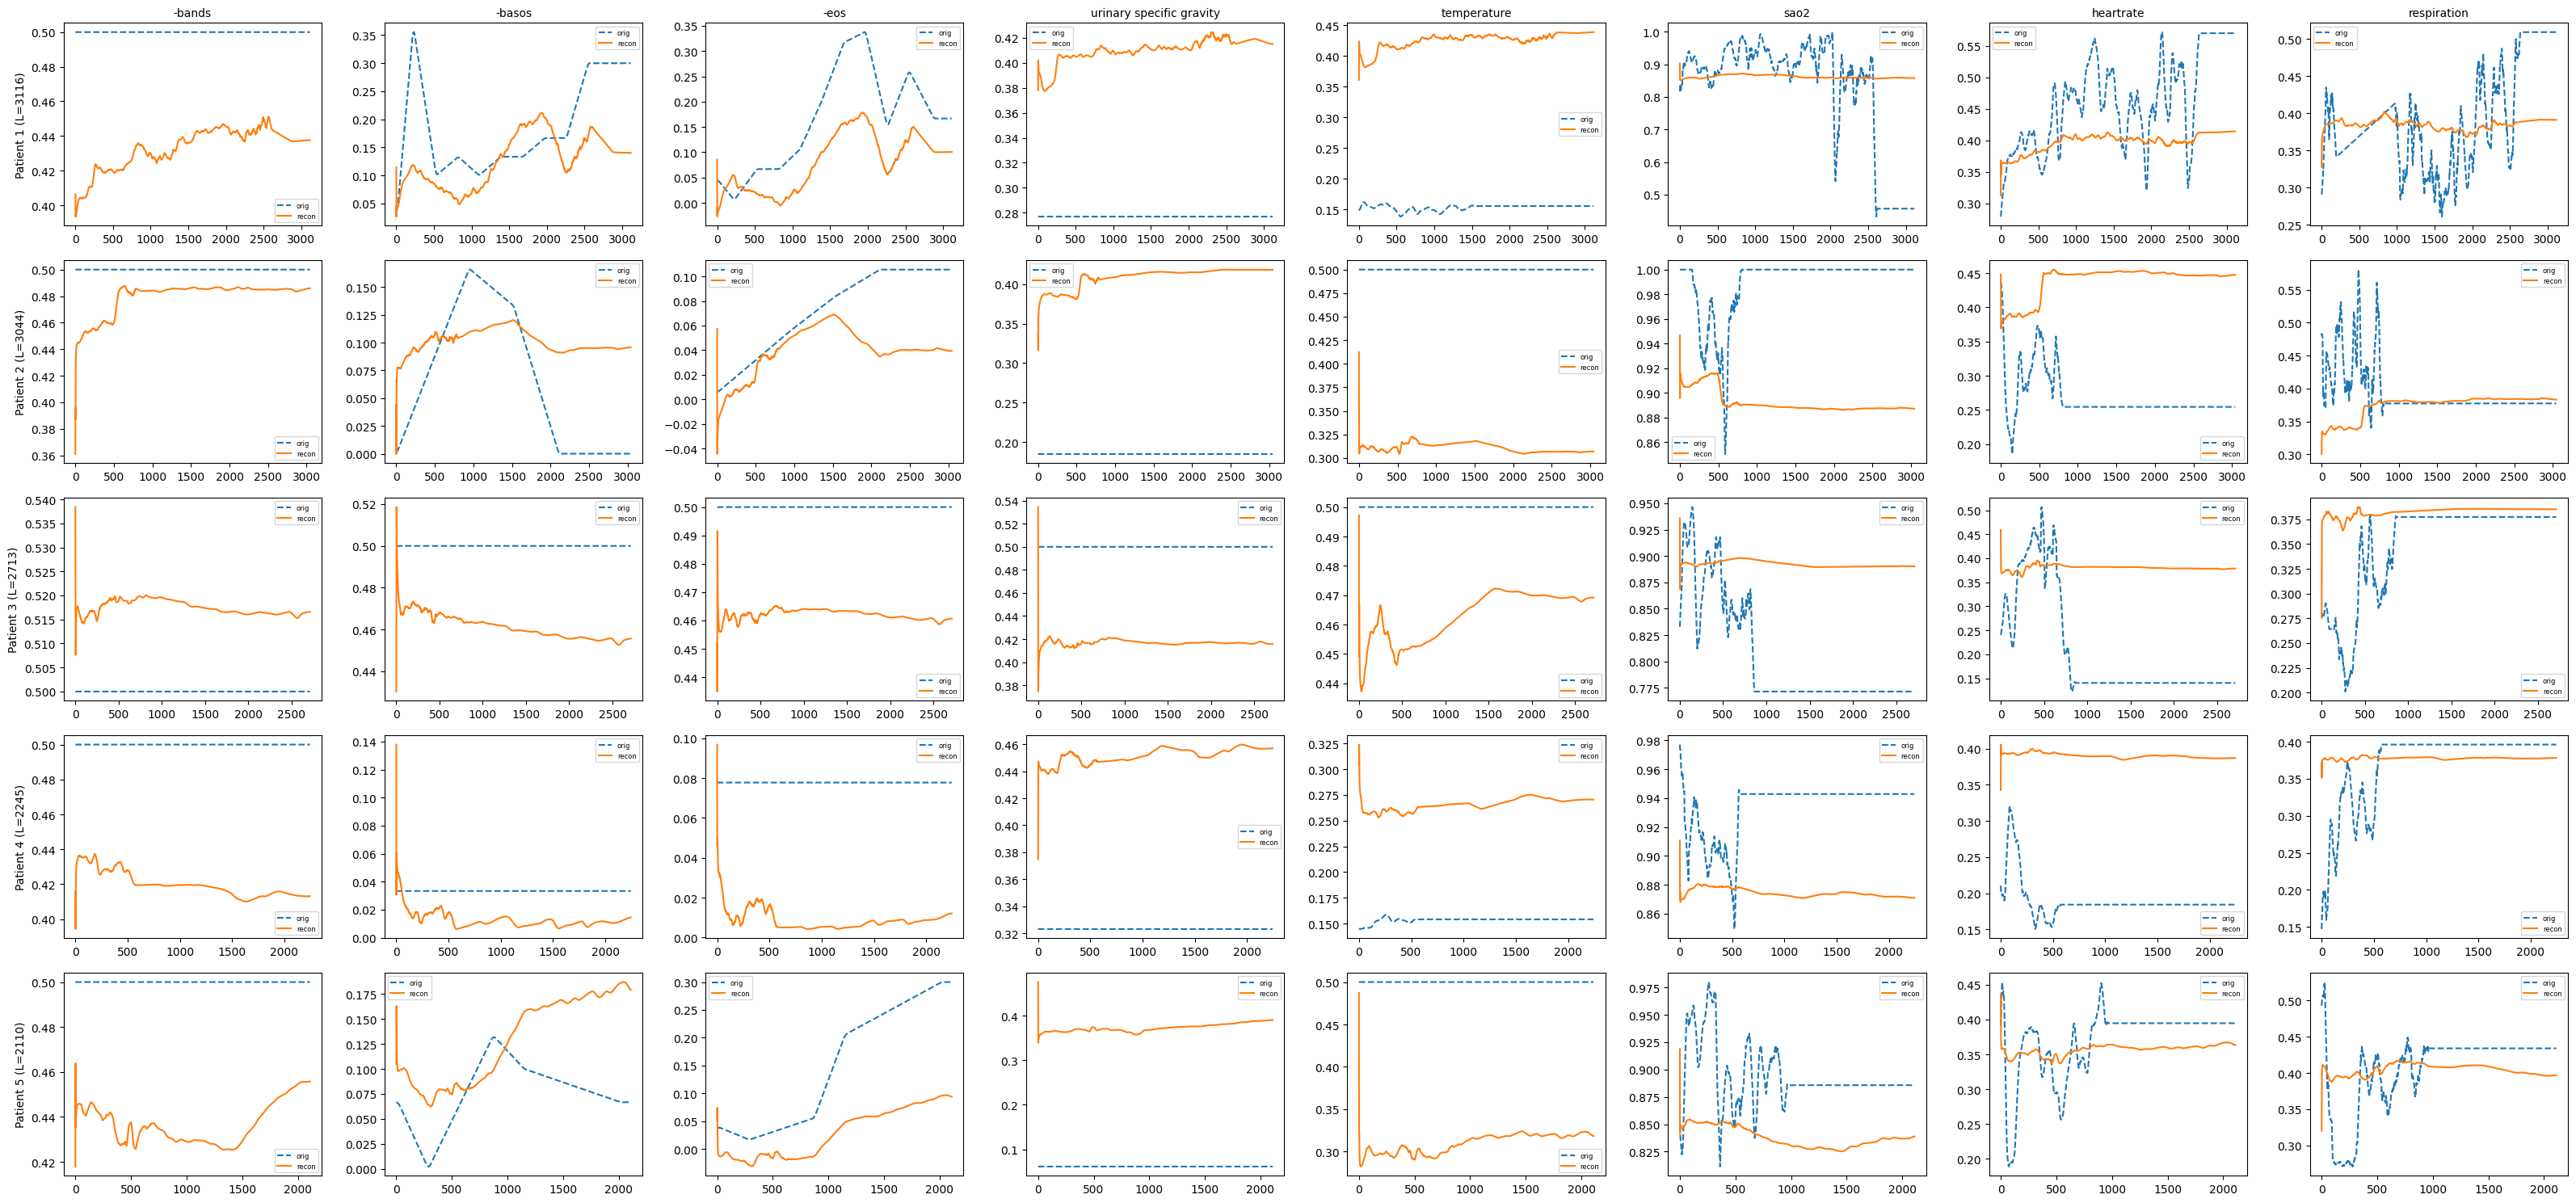

: 

In [ ]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]
selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model4, test_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)